In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
env = TictactoeEnv()

In [3]:
import random
random.seed(10)



In [4]:
# helper functions

#check if the game is over
def checkEnd(grid):
    # check rows and cols
    if np.any(np.sum(grid, axis=0) == 3) or np.any(np.sum(grid, axis=1) == 3):
        end = True
        winner = 'X'
    elif np.any(np.sum(grid, axis=0) == -3) or np.any(np.sum(grid, axis=1) == -3):
        end = True
        winner = 'O'
    # check diagnols
    elif grid[[0,1,2],[0,1,2]].sum() == 3 or grid[[0,1,2],[2,1,0]].sum() == 3:
        end = True
        winner = 'X'
    elif grid[[0,1,2],[0,1,2]].sum() == -3 or grid[[0,1,2],[2,1,0]].sum() == -3:
        end = True
        winner = 'O'
    # check if all the positions are filled
    elif (grid == 0).sum() == 0:
        end = True
        winner = None # no one wins
    else:
        end = False
        winner = None

    return end, winner

def m_opt(Q_table):
    player_q = QLearningAgent(epsilon=0, player='O',opponent='X', player_number=-1, opponent_number=1)
    player_q.Q_table = Q_table
    player_opt = OptimalPlayer(epsilon=0, player='X')

    env = TictactoeEnv()
    env.reset()
    grid, _, __ = env.observe()

    wins = 0
    losses = 0

    for game in range(500):
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act_update(grid)

            grid, end, winner = env.step(move, print_grid=False)
            if end:
                if winner == player_q.opponent:
                    losses += 1
                elif winner == player_q.player:
                    wins += 1
                env.reset()
                grid, _, __ = env.observe()
                if player_q.player == 'X':
                    player_q.player = 'O'
                    player_q.opponent = 'X'
                    player_q.player_number = -1
                    player_q.opponent_number = 1
                    player_opt = OptimalPlayer(epsilon=0, player='X')
                else:
                    player_q.player = 'X'
                    player_q.opponent = 'O'
                    player_q.player_number = 1
                    player_q.opponent_number = -1
                    player_opt = OptimalPlayer(epsilon=0, player='O')
                break
    m_opt = (wins - losses) / 500
    return m_opt


def m_rand(Q_table):
    player_q = QLearningAgent(epsilon=0, player='O',opponent='X', player_number=-1, opponent_number=1)
    player_q.Q_table = Q_table
    player_opt = OptimalPlayer(epsilon=1, player='X')
    env = TictactoeEnv()
    env.reset()
    grid, _, __ = env.observe()

    wins = 0
    losses = 0

    for game in range(500):
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act_update(grid)
                move_q = move

            grid, end, winner = env.step(move, print_grid=False)
            if end:
                if winner == player_q.opponent:
                    losses += 1
                elif winner == player_q.player:
                    wins += 1
                env.reset()
                grid, _, __ = env.observe()
                if player_q.player == 'X':
                    player_q.player = 'O'
                    player_q.opponent = 'X'
                    player_q.player_number = -1
                    player_q.opponent_number = 1
                    player_opt = OptimalPlayer(epsilon=1, player='X')
                else:
                    player_q.player = 'X'
                    player_q.opponent = 'O'
                    player_q.player_number = 1
                    player_q.opponent_number = -1
                    player_opt = OptimalPlayer(epsilon=1, player='O')
                break
    m_rand = (wins - losses) / 500
    return m_rand


In [5]:
class QLearningAgent:
    def __init__(self, epsilon=0.2, alpha=0.1, gamma=0.9, player='X', opponent='O', player_number=1, opponent_number=-1):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player
        self.opponent = opponent
        self.player_number = player_number
        self.opponent_number = opponent_number
        self.last_SA = None
        self.Q_table = {}

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def check_loss_tie(self, grid):
        avail = self.empty(grid)
        loss_counter = 0
        tie_counter = 0
        for pos in avail:
            new_grid = grid.copy()
            new_grid[pos] = self.opponent_number
            end, winner = checkEnd(new_grid)
            if end:
                if winner != None:
                    loss_counter += 1
                else:
                    tie_counter += 1
        if loss_counter == len(avail):
            return -1
        elif tie_counter == len(avail):
            return 0
        else:
            return 0



    def check_q_table_and_update(self, grid):
        state = tuple(grid.flatten())
        if state not in self.Q_table:
            avail = self.empty(grid)
            self.Q_table[state] = {}
            for pos in avail:
                self.Q_table[state][pos] = 0

        if self.last_SA is not None:
            #check if all q values are zero
            all_zero = True
            for pos in self.Q_table[state]:
                if self.Q_table[state][pos] != 0:
                    all_zero = False
            if all_zero:
                #get random action
                supposed_action = random.choice(list(self.Q_table[state]))
            else:
                supposed_action = max(self.Q_table[state], key=self.Q_table[state].get)
            possible_grid = grid.copy()
            possible_grid[supposed_action] = self.player_number
            # check if the game is over
            reward = 0
            end, winner = checkEnd(possible_grid)
            if end:
                if winner == self.player:
                    reward = 1
                    self.Q_table[state][supposed_action] = reward   
            else:
              # check that on the next move there is a 100% chance of losing or tie
                reward = self.check_loss_tie(possible_grid)
              
            temporal_difference = reward + self.gamma * self.Q_table[state][supposed_action] - self.Q_table[self.last_SA[0]][self.last_SA[1]]
            self.Q_table[self.last_SA[0]][self.last_SA[1]] += self.alpha * temporal_difference





    def act(self, grid):
        if np.random.random() < self.epsilon:
            avail = self.empty(grid)
            action = avail[random.randint(0, len(avail)-1)]
            return action

        else:
            state = tuple(grid.flatten())
            all_zero = True
            for pos in self.Q_table[state]:
                if self.Q_table[state][pos] != 0:
                    all_zero = False
            if all_zero:
                #get random action
                action = random.choice(list(self.Q_table[state]))
            else:
            # if not, go greedy
                action = max(self.Q_table[state], key=self.Q_table[state].get)

            return action


                    
    def act_update(self, grid):
        state = tuple(grid.flatten())
        if state not in self.Q_table:
            avail = self.empty(grid)
            self.Q_table[state] = {}
            for pos in avail:
                self.Q_table[state][pos] = 0

        action = self.act(grid)

        return action




## QUESTION 1

In [10]:

env.reset()
grid, _, __ = env.observe()
player_opt = OptimalPlayer(epsilon=0.5, player='X')
player_q = QLearningAgent(epsilon=0.2, player='O',opponent='X', player_number=-1, opponent_number=1)

epsilon=0.2
alpha=0.1
gamma=0.9

reward_sum = 0
avg_rewards = []

for game in range(20000):
    have_played = False
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            # player_q.check_q_table_and_update(grid)
            # move = player_q.act(grid)
            move = player_q.act_update(grid)
            move_q = move
            grid_q = tuple(grid.flatten())
            have_played = True

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            # print('-------------------------------------------')
            # print('Game end, winner is player ' + str(winner))
            # print('Optimal player = ' + str(player_opt.player))
            # print('Q player = ' + str(player_q.player))
            # print(env.reward(winner))
            if winner == player_q.opponent:
                reward = -1
            elif winner == player_q.player:
                reward = 1
            else:
                reward = 0

            player_q.Q_table[grid_q][move_q] = reward
            if winner == player_q.player:
                temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference          
            env.reset()
            grid, _, __ = env.observe()
            player_q.last_SA = None
            if player_q.player == 'X':
                player_q.player = 'O'
                player_q.opponent = 'X'
                player_q.player_number = -1
                player_q.opponent_number = 1
                player_opt = OptimalPlayer(epsilon=0.5, player='X')
            else:
                player_q.player = 'X'
                player_q.opponent = 'O'
                player_q.player_number = 1
                player_q.opponent_number = -1
                player_opt = OptimalPlayer(epsilon=0.5, player='O')

            reward_sum += reward
            if game%250 == 0 and game != 0:
                avg_rewards.append(reward_sum/250)
                reward_sum = 0
            # if game == 1000

            break
        
        if env.current_player == player_opt.player:
            if player_q.last_SA is not None:
                temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference
            if have_played:
                player_q.last_SA = (grid_q, move_q)
        
avg_rewards.append(reward_sum/250)

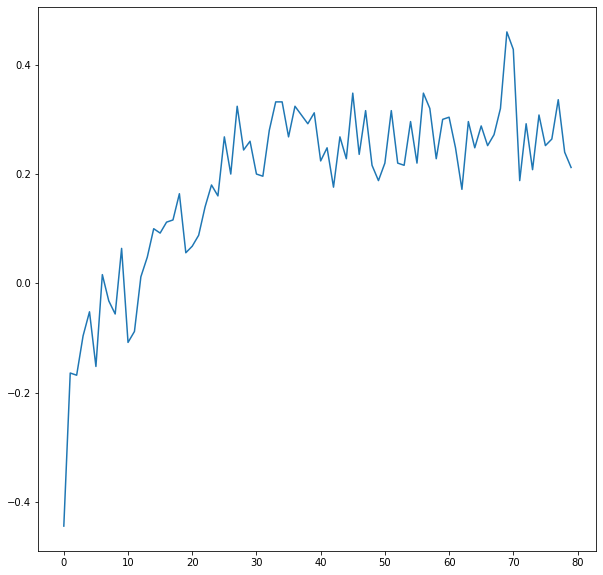

In [11]:
#plot a list of rewards
plt.figure(figsize=(10, 10))
plt.plot(avg_rewards)

Yes, the agent does learn to play Tic Tac Toe, we can see that clearly on the picture because on the first 15 dots approximately (3750 games) we lose more than win in average, but then we have a positive average reward and it keeps getting higher when the agent play more games. I chose an epsilon of 0.2, found that it was a good number after a couple of tries.

## QUESTION 2

In [6]:
env.reset()


max_epsilon=0.8
min_epsilon = 0.1


grid, _, __ = env.observe()



alpha=0.1
gamma=0.9


avg_rewards_total = []
n_list = [1, 1000, 10000, 20000, 40000]

for n_fixed in n_list:
    avg_rewards = []
    reward_sum = 0
    player_opt = OptimalPlayer(epsilon=0.5, player='X')
    player_q = QLearningAgent(epsilon=max_epsilon, player='O',opponent='X', player_number=-1, opponent_number=1)
    for game in range(20000):
        have_played = False
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act_update(grid)
                move_q = move
                grid_q = tuple(grid.flatten())
                have_played = True

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q.opponent:
                    reward = -1
                elif winner == player_q.player:
                    reward = 1
                else:
                    reward = 0

                player_q.Q_table[grid_q][move_q] = reward
                if winner == player_q.player:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference          
                env.reset()
                grid, _, __ = env.observe()
                player_q.last_SA = None
                if player_q.player == 'X':
                    player_q.player = 'O'
                    player_q.opponent = 'X'
                    player_q.player_number = -1
                    player_q.opponent_number = 1
                    player_opt = OptimalPlayer(epsilon=0.5, player='X')
                else:
                    player_q.player = 'X'
                    player_q.opponent = 'O'
                    player_q.player_number = 1
                    player_q.opponent_number = -1
                    player_opt = OptimalPlayer(epsilon=0.5, player='O')

                reward_sum += reward
                if game%250 == 0 and game != 0:
                    avg_rewards.append(reward_sum/250)
                    reward_sum = 0

                new_epsilon = max([min_epsilon, max_epsilon * (1- (game/n_fixed))])
                player_q.epsilon = new_epsilon
                break
            
            if env.current_player == player_opt.player:
                if player_q.last_SA is not None:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference
                if have_played:
                    player_q.last_SA = (grid_q, move_q)
            
    avg_rewards.append(reward_sum/250)
    avg_rewards_total.append(avg_rewards)

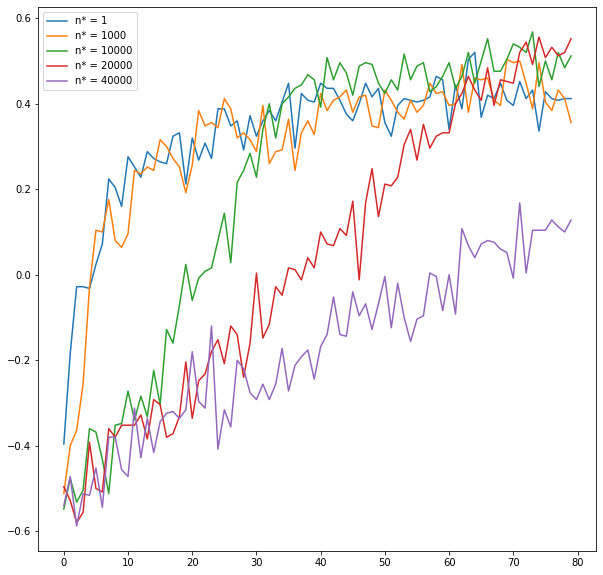

In [7]:
# plot lines
plt.figure(figsize=(10, 10))
plt.plot(avg_rewards_total[0], label = "n* = 1")
plt.plot(avg_rewards_total[1], label = "n* = 1000")
plt.plot(avg_rewards_total[2], label = "n* = 10000")
plt.plot(avg_rewards_total[3], label = "n* = 20000")
plt.plot(avg_rewards_total[4], label = "n* = 40000")


plt.legend()
plt.show()

Yes decreasing epsilon helps, we can see clearly on that on the lower n* values that get to a lower epsilon faster than the higher n* ones (the bigger the n* the slower we get from max epsilon to min epsilon), the average reward goes up way faster than the ones that get from a high epsilon value to a low one slower. But we also can see that the lower n* values also get kind of stuck faster, and some a little bit higher ones get to better results at the end. So we can conclude that decreasing the exploration rate too fast will make you get better results faster at the beggining, but you can get stuck on some point, so if you decrease this exploration rate slower, you can get better results at the end.

## QUESTION 3

In [ ]:
env.reset()

max_epsilon=0.8
min_epsilon = 0.1


grid, _, __ = env.observe()


alpha=0.1
gamma=0.9


n_list = [1, 1000, 10000, 20000, 40000]
m_opt_total_list = []
m_rand_total_list = []

for n_fixed in n_list:
    player_opt = OptimalPlayer(epsilon=0.5, player='X')
    player_q = QLearningAgent(epsilon=max_epsilon, player='O',opponent='X', player_number=-1, opponent_number=1)
    m_opt_n = []
    m_rand_n = []
    for game in range(20000):
        have_played = False
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act_update(grid)
                move_q = move
                grid_q = tuple(grid.flatten())
                have_played = True

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q.opponent:
                    reward = -1
                elif winner == player_q.player:
                    reward = 1
                else:
                    reward = 0

                player_q.Q_table[grid_q][move_q] = reward
                if winner == player_q.player:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference          
                env.reset()
                grid, _, __ = env.observe()
                player_q.last_SA = None
                if player_q.player == 'X':
                    player_q.player = 'O'
                    player_q.opponent = 'X'
                    player_q.player_number = -1
                    player_q.opponent_number = 1
                    player_opt.player = 'X'
                else:
                    player_q.player = 'X'
                    player_q.opponent = 'O'
                    player_q.player_number = 1
                    player_q.opponent_number = -1
                    player_opt.player = 'O'

                if game%250 == 0 and game != 0:
                    m_opt_value = m_opt(player_q.Q_table)
                    m_opt_n.append(m_opt_value)
                    m_rand_value = m_rand(player_q.Q_table)
                    m_rand_n.append(m_rand_value)
                new_epsilon = max([min_epsilon, max_epsilon * (1- (game/n_fixed))])
                player_q.epsilon = new_epsilon
                break
            
            if env.current_player == player_opt.player:
                if player_q.last_SA is not None:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference
                if have_played:
                    player_q.last_SA = (grid_q, move_q)
            
    m_opt_value = m_opt(player_q.Q_table)
    m_opt_n.append(m_opt_value)
    m_opt_total_list.append(m_opt_n)
    m_rand_value = m_rand(player_q.Q_table)
    m_rand_n.append(m_rand_value)
    m_rand_total_list.append(m_rand_n)

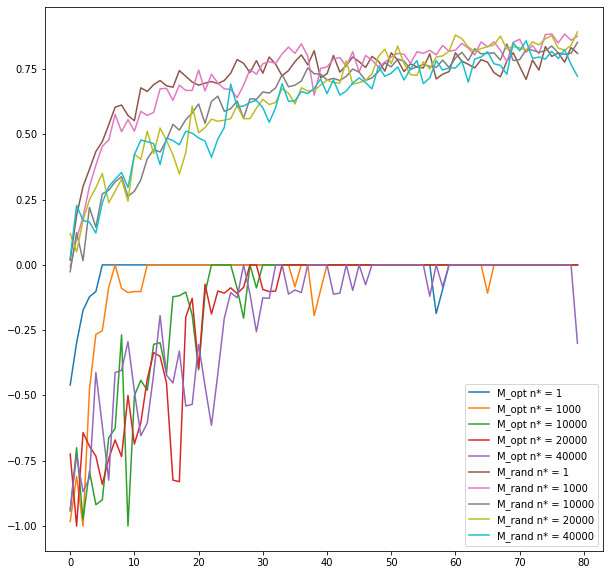

In [ ]:
# plot lines
plt.figure(figsize=(10, 10))
plt.plot(m_opt_total_list[0], label = "M_opt n* = 1")
plt.plot(m_opt_total_list[1], label = "M_opt n* = 1000")
plt.plot(m_opt_total_list[2], label = "M_opt n* = 10000")
plt.plot(m_opt_total_list[3], label = "M_opt n* = 20000")
plt.plot(m_opt_total_list[4], label = "M_opt n* = 40000")
plt.plot(m_rand_total_list[0], label = "M_rand n* = 1")
plt.plot(m_rand_total_list[1], label = "M_rand n* = 1000")
plt.plot(m_rand_total_list[2], label = "M_rand n* = 10000")
plt.plot(m_rand_total_list[3], label = "M_rand n* = 20000")
plt.plot(m_rand_total_list[4], label = "M_rand n* = 40000")





plt.legend()
plt.show()

These curves are similar to the ones on the previous question in terms of how the agent is learning, clearly we can see how we go from loosing almost every game to the expert to tie almost every single one. The difference between the M_opt and M_rand curves is that the M_opt goes up way faster than the M_rand, so we can conclude that playing against an expert gets a faster learning than playing against a random player.

## QUESTION 4

In [ ]:
env.reset()

max_epsilon=0.8
min_epsilon = 0.1


grid, _, __ = env.observe()


alpha=0.1
gamma=0.9

n_fixed = 1000
e_list = [0, 0.1, 0.2, 0.5, 0.8, 0.9]
m_opt_total_list_4 = []
m_rand_total_list_4 = []


for e in e_list:
    player_opt = OptimalPlayer(epsilon=e, player='X')
    player_q = QLearningAgent(epsilon=max_epsilon, player='O',opponent='X', player_number=-1, opponent_number=1)
    m_opt_n = []
    m_rand_n = []
    for game in range(20000):
        have_played = False
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:

                move = player_q.act_update(grid)
                move_q = move
                grid_q = tuple(grid.flatten())
                have_played = True

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q.opponent:
                    reward = -1
                elif winner == player_q.player:
                    reward = 1
                else:
                    reward = 0

                player_q.Q_table[grid_q][move_q] = reward
                if winner == player_q.player:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference          
                env.reset()
                grid, _, __ = env.observe()
                player_q.last_SA = None
                if player_q.player == 'X':
                    player_q.player = 'O'
                    player_q.opponent = 'X'
                    player_q.player_number = -1
                    player_q.opponent_number = 1
                    player_opt = OptimalPlayer(epsilon=e, player='X')
                else:
                    player_q.player = 'X'
                    player_q.opponent = 'O'
                    player_q.player_number = 1
                    player_q.opponent_number = -1
                    player_opt = OptimalPlayer(epsilon=e, player='O')

                reward_sum += reward
                if game%250 == 0 and game != 0:
                    m_opt_value = m_opt(player_q.Q_table)
                    m_opt_n.append(m_opt_value)
                    m_rand_value = m_rand(player_q.Q_table)
                    m_rand_n.append(m_rand_value)
                new_epsilon = max([min_epsilon, max_epsilon * (1- (game/n_fixed))])
                player_q.epsilon = new_epsilon
                break
            
            if env.current_player == player_opt.player:
                if player_q.last_SA is not None:
                    temporal_difference = gamma * player_q.Q_table[grid_q][move_q] - player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]]
                    player_q.Q_table[player_q.last_SA[0]][player_q.last_SA[1]] += alpha * temporal_difference
                if have_played:
                    player_q.last_SA = (grid_q, move_q)
            
    m_opt_value = m_opt(player_q.Q_table)
    m_opt_n.append(m_opt_value)
    m_opt_total_list_4.append(m_opt_n)
    m_rand_value = m_rand(player_q.Q_table)
    m_rand_n.append(m_rand_value)
    m_rand_total_list_4.append(m_rand_n)

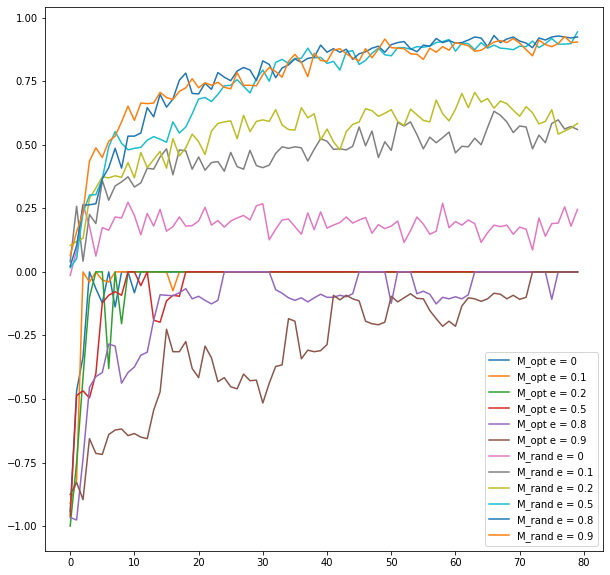

In [ ]:
# plot lines
plt.figure(figsize=(10, 10))
plt.plot(m_opt_total_list_4[0], label = "M_opt e = 0")
plt.plot(m_opt_total_list_4[1], label = "M_opt e = 0.1")
plt.plot(m_opt_total_list_4[2], label = "M_opt e = 0.2")
plt.plot(m_opt_total_list_4[3], label = "M_opt e = 0.5")
plt.plot(m_opt_total_list_4[4], label = "M_opt e = 0.8")
plt.plot(m_opt_total_list_4[5], label = "M_opt e = 0.9")

plt.plot(m_rand_total_list_4[0], label = "M_rand e = 0")
plt.plot(m_rand_total_list_4[1], label = "M_rand e = 0.1")
plt.plot(m_rand_total_list_4[2], label = "M_rand e = 0.2")
plt.plot(m_rand_total_list_4[3], label = "M_rand e = 0.5")
plt.plot(m_rand_total_list_4[4], label = "M_rand e = 0.8")
plt.plot(m_rand_total_list_4[5], label = "M_rand e = 0.9")

plt.legend()
plt.show()

I used several values of epsilon from 0 to 0.9, and we can see on the figure, that when we learn from a player that takes more random actions (higher epsilon) The agent learns slower on how to defend itself from an attack, we can say this because you can see on the M_opt curves that is a test versus an optimal player, how for the brown and purple the learning to tie a game against this player is slower ar than the other ones (e = 0.9 and 0.8). And this makes sense because we are training the agent against a player that makes random decisions most of the time, so the agent has not train a lot on losing games or what happens with a bad move, because the other player would take a random action, is harder to ger a negative reward. But this does not happen on the M_rand, and this also make sense, because we trained against a more random player, and we are testing it against a random player, so it makes sense that the learning is faster on higher epsilon. For lower epsilon is exactly the opposite.

## QUESTION 5

In [ ]:
opt_max_list = [max(x) for x in m_opt_total_list_4]
rand_max_list = [max(x) for x in m_rand_total_list_4]

opt_max = max(opt_max_list)
rand_max = max(rand_max_list)
print('M_opt max = ', opt_max)
print('M_rand max = ', rand_max)


M_opt max =  0.0
M_rand max =  0.944


## QUESTION 6

Q1(s,a) will have different values than Q2(s,a), and we can see this on the previous question, if we train an agent against an optimal player, he will lose every time until he has lost in all the ways posible so it will end up only tying, but the agent will not be able to win against an non optimal player, because it has probably almost never recieved a positive reward. So it will play for a tie always. And this is not the case when you train it against a random player, the agent will be prepared for a lot of different scenarios and will have the experience of winning and aim for that.

## QUESTION 7

In [ ]:
env.reset()

max_epsilon=0.8
min_epsilon = 0.1


grid, _, __ = env.observe()


alpha=0.1
gamma=0.9

e_list = [0, 0.1, 0.2, 0.5, 0.8, 0.9]
m_opt_total_list_7 = []
m_rand_total_list_7 = []

for e in e_list:
    player_q_1 = QLearningAgent(epsilon=e, player='X',opponent='O', player_number=1, opponent_number=-1)
    player_q_2 = QLearningAgent(epsilon=e, player='O',opponent='X', player_number=-1, opponent_number=1)
    m_opt_n = []
    m_rand_n = []
    for game in range(20000):
        have_played = False
        for j in range(9):
            if env.current_player == player_q_1.player:
                move = player_q_1.act_update(grid)
                player_q_2.Q_table = player_q_1.Q_table
                move_q_1 = move
                grid_q_1 = tuple(grid.flatten())
                have_played_1 = True
            else:

                move = player_q_2.act_update(grid)
                player_q_1.Q_table = player_q_2.Q_table
                move_q_2 = move
                grid_q_2 = tuple(grid.flatten())
                have_played_2 = True

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q_1.opponent:
                    reward_q_1 = -1
                    reward_q_2 = 1
                elif winner == player_q_1.player:
                    reward_q_1 = 1
                    reward_q_2 = -1
                else:
                    reward_q_1 = 0
                    reward_q_2 = 0

                player_q_1.Q_table[grid_q_1][move_q_1] = reward_q_1
                player_q_2.Q_table[grid_q_2][move_q_2] = reward_q_2
                if winner == player_q_1.player:
                    temporal_difference = gamma * player_q_1.Q_table[grid_q_1][move_q_1] - player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]]
                    player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]] += alpha * temporal_difference
                    player_q_2.Q_table = player_q_1.Q_table

                if winner == player_q_2.player:
                    temporal_difference = gamma * player_q_2.Q_table[grid_q_2][move_q_2] - player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]]
                    player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]] += alpha * temporal_difference
                    player_q_1.Q_table = player_q_2.Q_table            
                env.reset()
                grid, _, __ = env.observe()
                player_q_1.last_SA = None
                player_q_2.last_SA = None
                if player_q_1.player == 'X':
                    player_q_1.player = 'O'
                    player_q_1.opponent = 'X'
                    player_q_1.player_number = -1
                    player_q_1.opponent_number = 1

                    player_q_2.player = 'X'
                    player_q_2.opponent = 'O'
                    player_q_2.player_number = 1
                    player_q_2.opponent_number = -1
                else:
                    player_q_1.player = 'X'
                    player_q_1.opponent = 'O'
                    player_q_1.player_number = 1
                    player_q_1.opponent_number = -1

                    player_q_2.player = 'O'
                    player_q_2.opponent = 'X'
                    player_q_2.player_number = -1
                    player_q_2.opponent_number = 1

                if game%250 == 0 and game != 0:
                    m_opt_value = m_opt(player_q_1.Q_table)
                    m_opt_n.append(m_opt_value)
                    m_rand_value = m_rand(player_q_1.Q_table)
                    m_rand_n.append(m_rand_value)
                break
            
            if env.current_player == player_q_1.player:
                if player_q_2.last_SA is not None:
                    temporal_difference = gamma * player_q_2.Q_table[grid_q_2][move_q_2] - player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]]
                    player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]] += alpha * temporal_difference
                    player_q_1.Q_table = player_q_2.Q_table
                if have_played_2:
                    player_q_2.last_SA = (grid_q_2, move_q_2)

            else:
                if player_q_1.last_SA is not None:
                    temporal_difference = gamma * player_q_1.Q_table[grid_q_1][move_q_1] - player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]]
                    player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]] += alpha * temporal_difference
                    player_q_2.Q_table = player_q_1.Q_table
                if have_played_1:
                    player_q_1.last_SA = (grid_q_1, move_q_1)
            
    m_opt_value = m_opt(player_q_1.Q_table)
    m_opt_n.append(m_opt_value)
    m_opt_total_list_7.append(m_opt_n)
    m_rand_value = m_rand(player_q_1.Q_table)
    m_rand_n.append(m_rand_value)
    m_rand_total_list_7.append(m_rand_n)

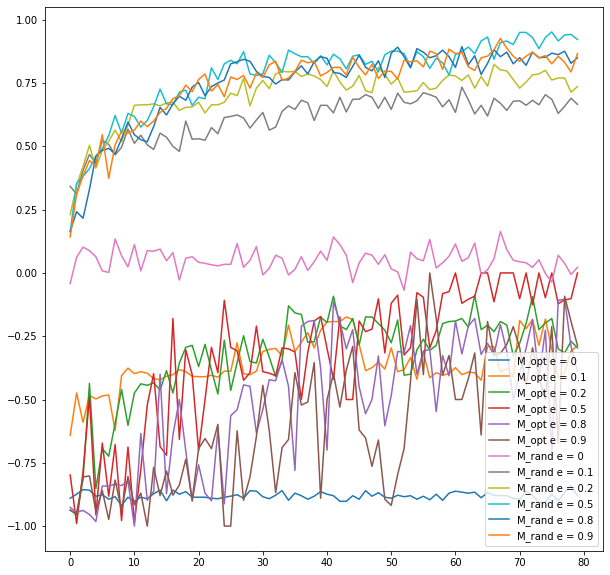

In [ ]:
# plot lines
plt.figure(figsize=(10, 10))
plt.plot(m_opt_total_list_7[0], label = "M_opt e = 0")
plt.plot(m_opt_total_list_7[1], label = "M_opt e = 0.1")
plt.plot(m_opt_total_list_7[2], label = "M_opt e = 0.2")
plt.plot(m_opt_total_list_7[3], label = "M_opt e = 0.5")
plt.plot(m_opt_total_list_7[4], label = "M_opt e = 0.8")
plt.plot(m_opt_total_list_7[5], label = "M_opt e = 0.9")

plt.plot(m_rand_total_list_7[0], label = "M_rand e = 0")
plt.plot(m_rand_total_list_7[1], label = "M_rand e = 0.1")
plt.plot(m_rand_total_list_7[2], label = "M_rand e = 0.2")
plt.plot(m_rand_total_list_7[3], label = "M_rand e = 0.5")
plt.plot(m_rand_total_list_7[4], label = "M_rand e = 0.8")
plt.plot(m_rand_total_list_7[5], label = "M_rand e = 0.9")

plt.legend()
plt.show()

Yes the agent learns, but not with every epsilon value, with every value that I tried, the agent learnt at different rates, except for epsilon = 0 because it will never explore for better options after finding some values, it will always stick to the same. We can also see that the performance against an optimal player does not go up in a stable matter, and this also makes sense because the agent is learning by playing against itself, so it does not know how to play against an expert.

## QUESTION 8

In [ ]:
env.reset()

max_epsilon=0.8
min_epsilon = 0.1


grid, _, __ = env.observe()


alpha=0.1
gamma=0.9


n_list = [1, 1000, 10000, 20000, 40000]
m_opt_total_list_8 = []
m_rand_total_list_8 = []


for n_fixed in n_list:
    player_q_1 = QLearningAgent(epsilon=max_epsilon, player='X',opponent='O', player_number=1, opponent_number=-1)
    player_q_2 = QLearningAgent(epsilon=max_epsilon, player='O',opponent='X', player_number=-1, opponent_number=1)
    m_opt_n = []
    m_rand_n = []
    for game in range(20000):
        have_played = False
        for j in range(9):
            if env.current_player == player_q_1.player:
                move = player_q_1.act_update(grid)
                player_q_2.Q_table = player_q_1.Q_table
                move_q_1 = move
                grid_q_1 = tuple(grid.flatten())
                have_played_1 = True
            else:

                move = player_q_2.act_update(grid)
                player_q_1.Q_table = player_q_2.Q_table
                move_q_2 = move
                grid_q_2 = tuple(grid.flatten())
                have_played_2 = True

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q_1.opponent:
                    reward_q_1 = -1
                    reward_q_2 = 1
                elif winner == player_q_1.player:
                    reward_q_1 = 1
                    reward_q_2 = -1
                else:
                    reward_q_1 = 0
                    reward_q_2 = 0

                player_q_1.Q_table[grid_q_1][move_q_1] = reward_q_1
                player_q_2.Q_table[grid_q_2][move_q_2] = reward_q_2
                if winner == player_q_1.player:
                    temporal_difference = gamma * player_q_1.Q_table[grid_q_1][move_q_1] - player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]]
                    player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]] += alpha * temporal_difference
                    player_q_2.Q_table = player_q_1.Q_table

                if winner == player_q_2.player:
                    temporal_difference = gamma * player_q_2.Q_table[grid_q_2][move_q_2] - player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]]
                    player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]] += alpha * temporal_difference
                    player_q_1.Q_table = player_q_2.Q_table            
                env.reset()
                grid, _, __ = env.observe()
                player_q_1.last_SA = None
                player_q_2.last_SA = None
                if player_q_1.player == 'X':
                    player_q_1.player = 'O'
                    player_q_1.opponent = 'X'
                    player_q_1.player_number = -1
                    player_q_1.opponent_number = 1

                    player_q_2.player = 'X'
                    player_q_2.opponent = 'O'
                    player_q_2.player_number = 1
                    player_q_2.opponent_number = -1
                else:
                    player_q_1.player = 'X'
                    player_q_1.opponent = 'O'
                    player_q_1.player_number = 1
                    player_q_1.opponent_number = -1

                    player_q_2.player = 'O'
                    player_q_2.opponent = 'X'
                    player_q_2.player_number = -1
                    player_q_2.opponent_number = 1

                if game%250 == 0 and game != 0:
                    m_opt_value = m_opt(player_q_1.Q_table)
                    m_opt_n.append(m_opt_value)
                    m_rand_value = m_rand(player_q_1.Q_table)
                    m_rand_n.append(m_rand_value)
                new_epsilon = max([min_epsilon, max_epsilon * (1- (game/n_fixed))])
                player_q_1.epsilon = new_epsilon
                player_q_2.epsilon = new_epsilon
                break
            
            if env.current_player == player_q_1.player:
                if player_q_2.last_SA is not None:
                    temporal_difference = gamma * player_q_2.Q_table[grid_q_2][move_q_2] - player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]]
                    player_q_2.Q_table[player_q_2.last_SA[0]][player_q_2.last_SA[1]] += alpha * temporal_difference
                    player_q_1.Q_table = player_q_2.Q_table
                if have_played_2:
                    player_q_2.last_SA = (grid_q_2, move_q_2)

            else:
                if player_q_1.last_SA is not None:
                    temporal_difference = gamma * player_q_1.Q_table[grid_q_1][move_q_1] - player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]]
                    player_q_1.Q_table[player_q_1.last_SA[0]][player_q_1.last_SA[1]] += alpha * temporal_difference
                    player_q_2.Q_table = player_q_1.Q_table
                if have_played_1:
                    player_q_1.last_SA = (grid_q_1, move_q_1)
            
    m_opt_value = m_opt(player_q_1.Q_table)
    m_opt_n.append(m_opt_value)
    m_opt_total_list_8.append(m_opt_n)
    m_rand_value = m_rand(player_q_1.Q_table)
    m_rand_n.append(m_rand_value)
    m_rand_total_list_8.append(m_rand_n)

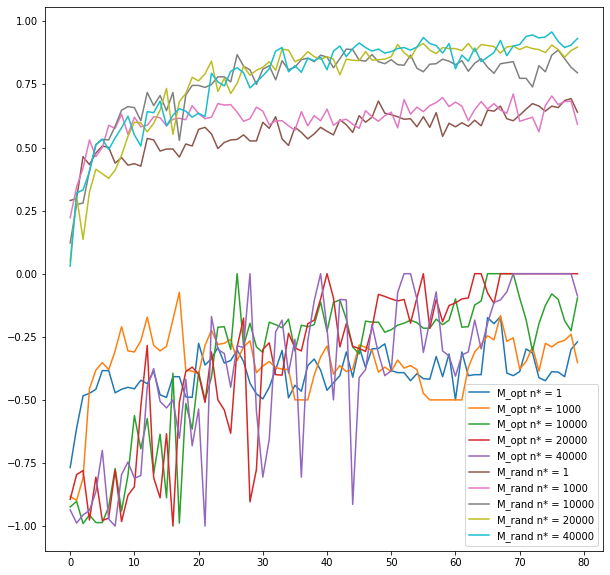

In [ ]:
# plot lines
plt.figure(figsize=(10, 10))
plt.plot(m_opt_total_list_8[0], label = "M_opt n* = 1")
plt.plot(m_opt_total_list_8[1], label = "M_opt n* = 1000")
plt.plot(m_opt_total_list_8[2], label = "M_opt n* = 10000")
plt.plot(m_opt_total_list_8[3], label = "M_opt n* = 20000")
plt.plot(m_opt_total_list_8[4], label = "M_opt n* = 40000")
plt.plot(m_rand_total_list_8[0], label = "M_rand n* = 1")
plt.plot(m_rand_total_list_8[1], label = "M_rand n* = 1000")
plt.plot(m_rand_total_list_8[2], label = "M_rand n* = 10000")
plt.plot(m_rand_total_list_8[3], label = "M_rand n* = 20000")
plt.plot(m_rand_total_list_8[4], label = "M_rand n* = 40000")





plt.legend()
plt.show()

The M_rand test showed that starting with a higher epsilon and then start decreasing it helps the agent get a better result (n = 10.000, 20.000 and 40.000 have better results than n = 1000 or 1), but on the M_opt test the results are not that clear, the same as the question 7, our agent is not that well prepared to play against an expert. The efect of epsilon is that the higher it is the higher the exploration will be (choose random action instead of the best one known) and as it gets lower, we explore less.

## QUESTION 9


In [ ]:
opt_max_list = [max(x) for x in m_opt_total_list_8]
rand_max_list = [max(x) for x in m_rand_total_list_8]

opt_max = max(opt_max_list)
rand_max = max(rand_max_list)
print('M_opt max = ', opt_max)
print('M_rand max = ', rand_max)


M_opt max =  0.0
M_rand max =  0.958


## QUESTION 10

STATE1: (CROSS TURN)
|   |   |   |
|   |   |   |
|   |   |   |

STATE2 (CROSS TURN):
|   |   |   |
| O | O | X |
| X | X | O |

STATE3: (CIRCLE TURN)
| O |   | X |
|   | X | X |
| O | X | O |



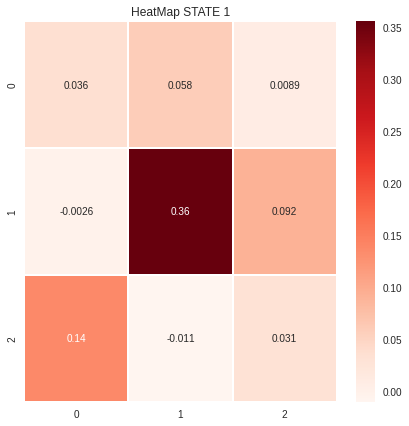

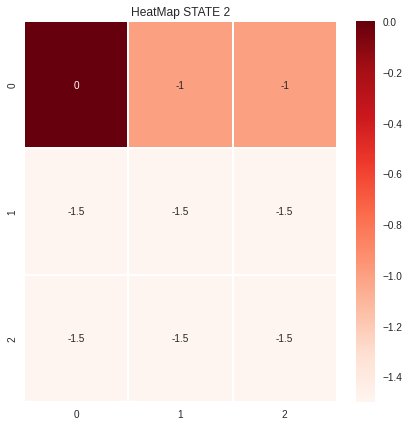

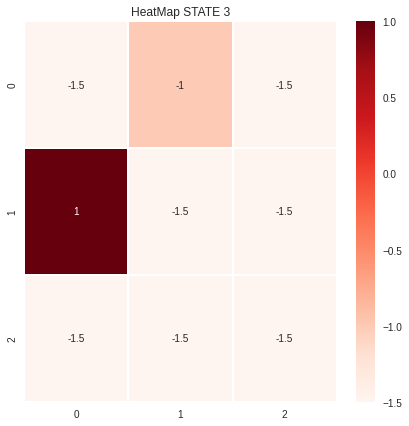

In [ ]:
# https://www.askpython.com/python/examples/heatmaps-in-python
plt.style.use("seaborn")
 
# 2. Generate a 10x10 random integer matrix
data = np.random.rand(10,10)
state1 = (0,0,0,0,0,0,0,0,0)
state2 = (0,0,0,-1,-1,1,1,1,-1)
state3 = (-1,0,1,0,1,1,-1,1,-1)

print('STATE1: (CROSS TURN)')
print('|   |   |   |\n|   |   |   |\n|   |   |   |\n')
print('STATE2 (CROSS TURN):')
print('|   |   |   |\n| O | O | X |\n| X | X | O |\n')
print('STATE3: (CIRCLE TURN)')
print('| O |   | X |\n|   | X | X |\n| O | X | O |\n')

lista = []
for y in range(3):
    fila = []
    for x in range(3):
        if (y, x) in player_q_1.Q_table[state1]:
            fila.append(player_q_1.Q_table[state1][(y,x)])
        else:
            fila.append(-1.5)
    lista.append(fila)

data = np.array(lista)

 
# 3. Plot the heatmap
plt.figure(figsize=(7,7))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, cmap = 'Reds')
plt.title( "HeatMap STATE 1" )
lista2 = []
for y in range(3):
    fila = []
    for x in range(3):
        if (y, x) in player_q_1.Q_table[state2]:
            fila.append(player_q_1.Q_table[state2][(y,x)])
        else:
            fila.append(-1.5)
    lista2.append(fila)

data2 = np.array(lista2)

 
# 3. Plot the heatmap
plt.figure(figsize=(7,7))
heat_map = sns.heatmap( data2, linewidth = 1 , annot = True, cmap = 'Reds')
plt.title( "HeatMap STATE 2" )

lista3 = []
for y in range(3):
    fila = []
    for x in range(3):
        if (y, x) in player_q_1.Q_table[state3]:
            fila.append(player_q_1.Q_table[state3][(y,x)])
        else:
            fila.append(-1.5)
    lista3.append(fila)

data3 = np.array(lista3)


 
# 3. Plot the heatmap
plt.figure(figsize=(7,7))
heat_map = sns.heatmap( data3, linewidth = 1 , annot = True, cmap='Reds')
plt.title( "HeatMap STATE 3" )
plt.show()

The result makes a lot of sense, on the first state, we have an empty Tic Tac Toe game, and the highest Q value by far is to choose the center spot, that would be the optimal according to the optimal policy. On the seccond state, if we choose anything but the left higher corner, we can lose on the next turn, and in any other case we would tie, and the Q values say the same thing, the higher q value is the left high corner to get the tie and not risk a loss. And finally the third state we have two options, in one we win and on the other, the oponnent would automatically on the next turn, and we have the corresponding correct Q values.